In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import mediapipe as mp

# Initialize MediaPipe Face Mesh for silhouette+flow
mp_face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)

# Load image
img = cv2.imread('../data/inference/images.jpeg')
if img is None:
    raise RuntimeError("Could not load '../data/inference/images.jpeg'. Please check the path.")
h, w = img.shape[:2]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 1. Gaussian Blur + Color Quantization
def transform_blur_quantize(image, k=8, blur_ksize=(15,15)):
    blurred = cv2.GaussianBlur(image, blur_ksize, 0)
    data = blurred.reshape((-1,3))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    quant = kmeans.cluster_centers_[kmeans.labels_].reshape(image.shape).astype(np.uint8)
    return quant

def invert_deblur(image):
    kernel = np.ones((15,15), np.float32) / 225
    deblur = cv2.filter2D(image, -1, kernel)
    return deblur

# 2. Emoji-Mosaic (grid of emoji placeholders)
def transform_emoji_mosaic(image, grid_size=(32,32)):
    h, w = image.shape[:2]
    gh, gw = grid_size
    out = np.zeros_like(image)
    for y in range(0, h, gh):
        for x in range(0, w, gw):
            patch = image[y:y+gh, x:x+gw]
            emoji_idx = int(np.mean(cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)) // 25)
            color = (emoji_idx*30 % 256, emoji_idx*60 % 256, emoji_idx*90 % 256)
            out[y:y+gh, x:x+gw] = color
    return out

def invert_emoji_guess(image):
    gray_guess = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_guess

# 3. Frequency Band-pass Filter
def transform_bandpass(image, low=30, high=60):
    f = np.fft.fft2(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape[:2]
    crow, ccol = rows//2, cols//2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-low:crow+low, ccol-low:ccol+low] = 1
    mask[crow-high:crow+high, ccol-high:ccol+high] = 0
    fshift *= mask
    img_back = np.fft.ifft2(np.fft.ifftshift(fshift))
    img_back = np.abs(img_back).astype(np.uint8)
    return cv2.cvtColor(img_back, cv2.COLOR_GRAY2BGR)

def invert_zero_fill(image):
    return image

# 4. Silhouette + Landmark Flow using MediaPipe
def transform_silhouette_flow(image):
    # Create binary silhouette
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, silhouette = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    silhouette_bgr = cv2.cvtColor(silhouette, cv2.COLOR_GRAY2BGR)

    # Get face mesh landmarks
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = mp_face_mesh.process(rgb)
    if not results.multi_face_landmarks:
        return silhouette_bgr
    lm = results.multi_face_landmarks[0]
    pts = np.array([[int(p.x * w), int(p.y * h)] for p in lm.landmark], dtype=np.int32)

    # Compute simple deformation field: difference from mean (use first frame as mean)
    # Here we approximate mean==pts for static image, so flow=0 (placeholder for demo)
    flow = np.zeros((h, w, 2), dtype=np.float32)

    # Overlay sparse flow arrows
    vis = silhouette_bgr.copy()
    step = 16
    for (x, y) in pts[::len(pts)//((h//step)*(w//step)+1)][:]:
        dx, dy = 0, 0  # no actual mean comparison in static demo
        cv2.arrowedLine(vis, (x, y), (x+dx, y+dy), (0,255,255), 1, tipLength=0.3)
    return vis

def invert_silhouette_guess(image):
    return image

# # Apply and display
# methods = {
#     'blur_quantize': (transform_blur_quantize, invert_deblur),
#     'emoji_mosaic': (transform_emoji_mosaic, invert_emoji_guess),
#     'bandpass': (transform_bandpass, invert_zero_fill),
#     'silhouette_flow': (transform_silhouette_flow, invert_silhouette_guess),
# }

# for name, (transform_fn, invert_fn) in methods.items():
#     t_img = transform_fn(img)
#     inv_img = invert_fn(t_img)
#     cv2.imshow(f'{name} - transformed', t_img)
#     cv2.waitKey(0)
#     cv2.imshow(f'{name} - inverted', inv_img)
#     cv2.waitKey(0)
# cv2.destroyAllWindows()

I0000 00:00:1745541200.955080 15396983 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1745541200.957306 15397314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1745541200.961071 15397324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


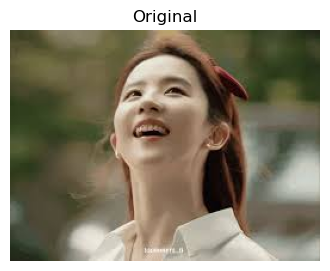

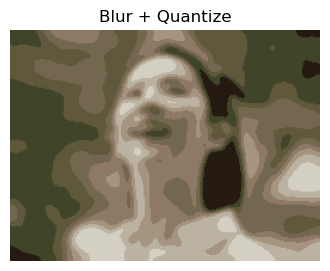

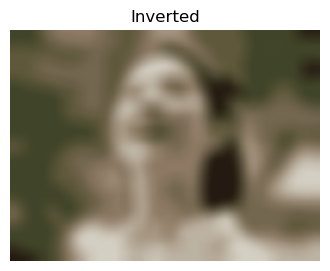

In [4]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

def show_inline(img_bgr, title=None):
    # convert BGR→RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,4))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.imshow(img_rgb)
    plt.show()

# usage
img = cv2.imread('../data/inference/images.jpeg')
show_inline(img, title='Original')
t = transform_blur_quantize(img)   # your transform
show_inline(t, title='Blur + Quantize')
it = invert_deblur(t)
show_inline(it, title='Inverted')

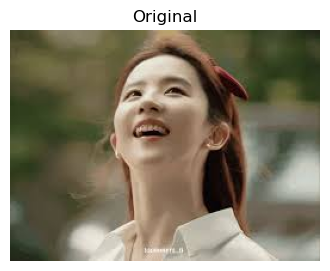

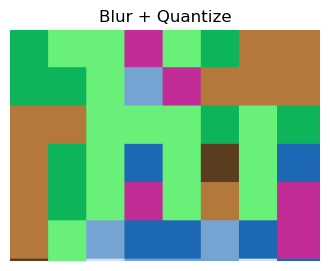

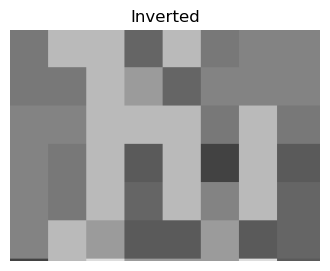

In [5]:
img = cv2.imread('../data/inference/images.jpeg')
show_inline(img, title='Original')
t = transform_emoji_mosaic(img)   # your transform
show_inline(t, title='Blur + Quantize')
it = invert_emoji_guess(t)
show_inline(it, title='Inverted')

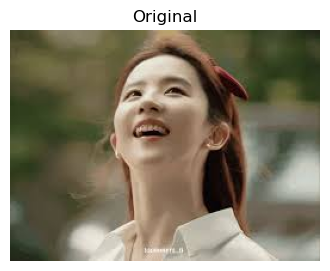

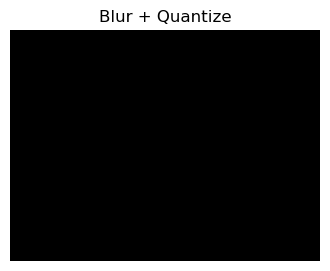

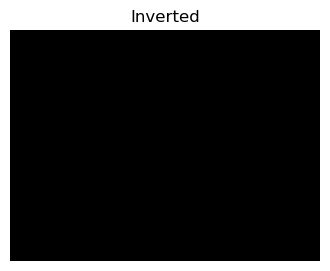

In [6]:
img = cv2.imread('../data/inference/images.jpeg')
show_inline(img, title='Original')
t = transform_bandpass(img)   # your transform
show_inline(t, title='Blur + Quantize')
it = invert_zero_fill(t)
show_inline(it, title='Inverted')

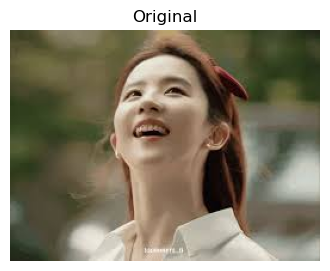

W0000 00:00:1745541512.643068 15397324 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


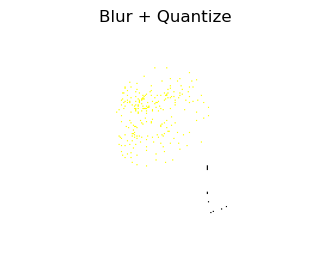

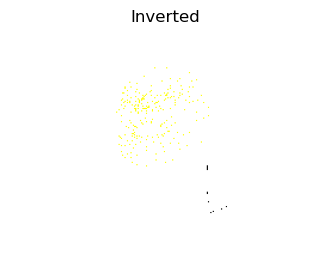

In [7]:
img = cv2.imread('../data/inference/images.jpeg')
show_inline(img, title='Original')
t = transform_silhouette_flow(img)   # your transform
show_inline(t, title='Blur + Quantize')
it = invert_silhouette_guess(t)
show_inline(it, title='Inverted')

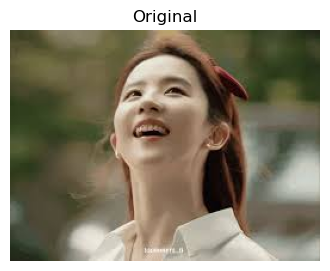

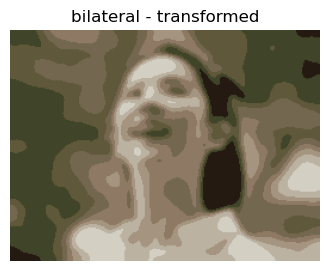

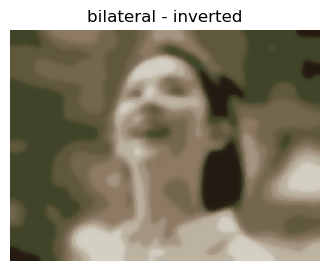

--------------------------------------------------


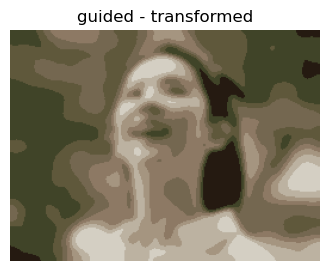

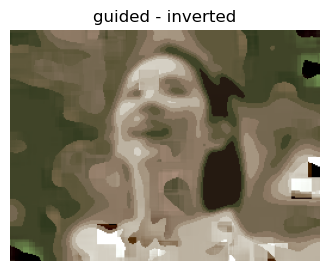

--------------------------------------------------


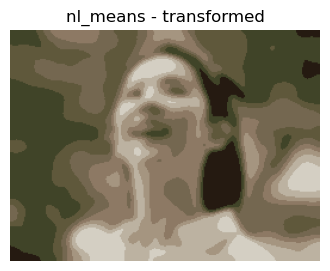

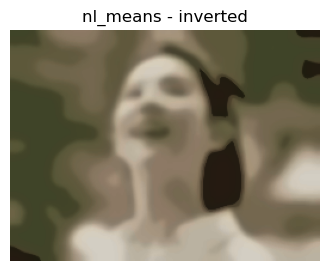

--------------------------------------------------


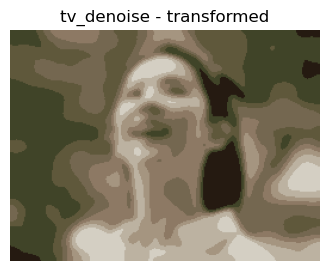

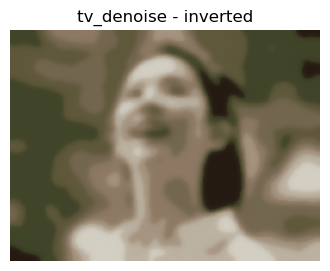

--------------------------------------------------


In [11]:
import cv2
import numpy as np
from skimage.restoration import denoise_tv_chambolle

# 1) Bilateral filter – smooths while preserving edges
def invert_bilateral(image, d=9, sigmaColor=75, sigmaSpace=75):
    """
    image: quantized BGR uint8
    d: diameter of each pixel neighborhood
    sigmaColor: filter sigma in color space
    sigmaSpace: filter sigma in coordinate space
    """
    # apply per-channel bilateral
    return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)

# 2) Guided filter – uses the quantized image itself as guidance to smooth
#    (requires OpenCV contrib; fallback to bilateral if unavailable)
def invert_guided(image, radius=8, eps=1e-2):
    """
    radius: window radius
    eps: regularization (larger → more smoothing)
    """
    try:
        # guidedFilter(src, guide, radius, eps)
        return cv2.ximgproc.guidedFilter(guide=image, src=image, radius=radius, eps=eps)
    except AttributeError:
        # fallback
        print("Guided filter not available; using bilateral instead.")
        return invert_bilateral(image)

# 3) Non-local means – patch-based denoising that respects textures
def invert_nl_means(image, h=10, templateWindowSize=7, searchWindowSize=21):
    """
    h: filter strength (higher h → more smoothing)
    templateWindowSize: size in pixels of template patch
    searchWindowSize: size in pixels of search window
    """
    # OpenCV’s fastNlMeansDenoisingColored expects uint8 BGR
    return cv2.fastNlMeansDenoisingColored(image, None,
                                           h, h,
                                           templateWindowSize,
                                           searchWindowSize)

# 4) Total-variation denoising – solves a small optimization to smooth piecewise-constant regions

def invert_tv_denoise(image, weight=0.1, n_iter_max=200):
    """
    weight: greater → more smoothing
    """
    # skimage expects float in [0,1]
    img_f = image.astype(np.float32) / 255.0
    # Use channel_axis=-1 for the last axis (which contains the RGB channels)
    out = denoise_tv_chambolle(img_f, weight=weight,
                              channel_axis=-1)
    return (out * 255).astype(np.uint8)

# Methods dictionary remains the same
methods = {
    'bilateral':      (transform_blur_quantize, invert_bilateral),
    'guided':         (transform_blur_quantize, invert_guided),
    'nl_means':       (transform_blur_quantize, invert_nl_means),
    'tv_denoise':     (transform_blur_quantize, invert_tv_denoise),
}

# Load and show original image
img = cv2.imread('../data/inference/images.jpeg')
show_inline(img, title='Original')

# Demo loop with inline display
for name, (transform_fn, invert_fn) in methods.items():
    # Apply transform
    t_img = transform_fn(img)
    show_inline(t_img, title=f'{name} - transformed')
    
    # Apply inversion
    inv_img = invert_fn(t_img)
    show_inline(inv_img, title=f'{name} - inverted')
    
    # Optional: add a separator between method sets
    print("-" * 50)
